In [1]:
import cv2
import time
import numpy as np
from matplotlib import pyplot as plt
from imu_bno import Imu
# from PIL import Image

from adafruit_bno08x import BNO_REPORT_ACCELEROMETER, BNO_REPORT_GYROSCOPE, BNO_REPORT_MAGNETOMETER, BNO_REPORT_GRAVITY, BNO_REPORT_ROTATION_VECTOR, BNO_REPORT_GEOMAGNETIC_ROTATION_VECTOR
import busio

import cv2
from IPython.display import display, Image
from scipy.spatial.transform import Rotation as R

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import skimage as ski

# Camera reading frequency

In [ ]:


cap = cv2.VideoCapture(0)
intervals = []

n = 5000
start_all = time.time()
for _ in range(n):
    start = time.time()
    ret, frame = cap.read()
    end = time.time()
    intervals.append(end-start)
    start = end
end_all = time.time()

print(n/(end_all-start_all))
print(min(intervals))
print(max(intervals))
print((sum(intervals)/len(intervals)))
cap.release()

In [ ]:
# intervals = [x**(-1) for x in intervals]
plt.hist(intervals)

# Imu

In [ ]:
i2c = busio.I2C((1, 14), (1, 15))
dev = Imu(i2c, address=0x4b)
dev.enable_feature(BNO_REPORT_GRAVITY)

In [ ]:
n = 5000
intervals = []
start_all = time.time()
for _ in range(n):
    start = time.time()
    _ = dev.gravity
    end = time.time()
    intervals.append(end-start)
    start = end
end_all = time.time()

print(n/(end_all-start_all))
print(min(intervals))
print(max(intervals))
print((sum(intervals)/len(intervals)))

In [ ]:
# intervals = [x**(-1) for x in intervals]
plt.hist(intervals)

# Вывод

Средняя частота чтения с камеры ~29 fps. При этом максимальный возможный интервал соответствует ~4 Гц (Скорее вссего первое чтение)
>
>
Чтение иму составляет ~600 Гц, с максимальным интервалом ~40 Гц.
>
>
Первый вариант синхронизации данных:
>
>
Чтение фрейма, затем чтение IMU

# Проверка камеры

In [2]:
import cv2
from IPython.display import display, Image

video = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        frame = cv2.flip(frame, 1)
        # print(frame.shape, type(frame))
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

# Gravity

In [71]:
display_handle=display(None, display_id=True)
try:   
    i2c = busio.I2C((1, 14), (1, 15))
    device = Imu(i2c, address=0x4b)
    device.enable_feature(BNO_REPORT_GRAVITY)
    X = 400
    Y = 400
    G = 9.80665
    while True:
        g1b, g2b, g3b = device.gravity

        xb = int(((g1b + G) / (2 * G)) * X) - 1
        yb = int(((-g2b + G) / (2 * G)) * Y) - 1
        
        image = np.ones((X, Y), dtype = np.uint8)
        image.fill(0)
        for y_ in range(yb-5, yb+5):
            image[y_][xb-5:xb+5] = 255
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        # image = cv2.flip(image, 1)
        # print(image.shape, type(image))
        _, image = cv2.imencode('.jpeg', image)
        display_handle.update(Image(data=image.tobytes()))
        
except KeyboardInterrupt:
    display_handle.update(None)
    pass

None

# Odom

In [55]:
#https://github.com/adafruit/Adafruit_CircuitPython_BNO08x/blob/main/examples/bno08x_find_heading.py
from math import atan2, sqrt, pi, degrees, radians, cos, sin
import math
i2c = busio.I2C((1, 14), (1, 15))
device = Imu(i2c, address=0x4b)
device.enable_feature(BNO_REPORT_GRAVITY)
device.enable_feature(BNO_REPORT_ROTATION_VECTOR)
device.enable_feature(BNO_REPORT_GEOMAGNETIC_ROTATION_VECTOR)

#https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles
def find_heading(dqw, dqx, dqy, dqz):
    norm = sqrt(dqw * dqw + dqx * dqx + dqy * dqy + dqz * dqz)
    dqw = dqw / norm
    dqx = dqx / norm
    dqy = dqy / norm
    dqz = dqz / norm

    ysqr = dqy * dqy

    t3 = +2.0 * (dqw * dqz + dqx * dqy)
    t4 = +1.0 - 2.0 * (ysqr + dqz * dqz)
    yaw_raw = atan2(t3, t4)
    yaw = yaw_raw * 180.0 / pi
    if yaw > 0:
        yaw = 360 - yaw
    else:
        yaw = abs(yaw)
    return yaw  # heading in 360 clockwise

def find_roll(dqw, dqx, dqy, dqz):
    norm = sqrt(dqw * dqw + dqx * dqx + dqy * dqy + dqz * dqz)
    dqw = dqw / norm
    dqx = dqx / norm
    dqy = dqy / norm
    dqz = dqz / norm
    sinr_cosp = +2.0 * (dqw * dqx + dqy * dqz)
    cosr_cosp = +1.0 - 2.0 * (dqx * dqx + dqy * dqy)
    roll_raw = atan2(sinr_cosp, cosr_cosp)
    roll = roll_raw * 180.0 / pi
    if roll > 0:
        roll = 360 - roll
    else:
        roll = abs(roll)
    return roll

def find_pitch(dqw, dqx, dqy, dqz):
    norm = sqrt(dqw * dqw + dqx * dqx + dqy * dqy + dqz * dqz)
    dqw = dqw / norm
    dqx = dqx / norm
    dqy = dqy / norm
    dqz = dqz / norm
    sinp = sqrt(+1.0 + 2.0 * (dqw * dqy - dqx * dqz))
    cosp = sqrt(+1.0 - 2.0 * (dqw * dqy - dqx * dqz))
    pitch_raw = +2.0 * atan2(sinp, cosp) - (pi / 2.0);
    pitch = pitch_raw * 180.0 / pi
    if pitch > 0:
        pitch = 360 - pitch
    else:
        pitch = abs(pitch)
    return pitch

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

None

/tmp/ipykernel_2817/3277913383.py:51: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


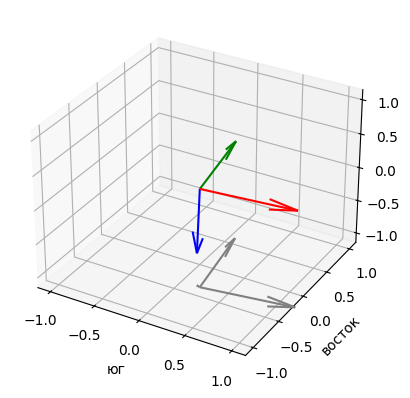

In [56]:
fig = plt.figure()
display_handle=display(None, display_id=True)
try:   
    X = 640
    Y = 480
    while True:

        quat_i, quat_j, quat_k, quat_real = device.quaternion
        heading = find_heading(quat_real, quat_i, quat_j, quat_k)
        pitch = find_pitch(quat_real, quat_i, quat_j, quat_k)
        roll = find_roll(quat_real, quat_i, quat_j, quat_k)
        
        r = R.from_quat([quat_i, quat_j, quat_k, quat_real])
        vec_x = np.array([1., 0., 0.])
        vec_y = np.array([0., -1., 0.])
        vec_z = np.array([0., 0., -1.])

        vec_x = r.apply(vec_x)
        vec_y = r.apply(vec_y)
        vec_z = r.apply(vec_z)

        x_shadows = [[0, vec_x[1], vec_x[2]], [vec_x[0], 0, vec_x[2]], [vec_x[0], vec_x[1], 0]]
        
        image = np.ones((Y, X), dtype = np.uint8)
        # image.fill(255)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        
        
        ax = fig.add_subplot(111, projection='3d')

        ax.quiver(0, 0, -1.5, vec_x[0], vec_x[1], 0, color='gray')
        ax.quiver(0, 0, -1.5, vec_y[0], vec_y[1], 0, color='gray')
        ax.quiver(0, 0, -1.5, vec_z[0], vec_z[1], 0, color='gray')

        ax.quiver(0, 0, 0, vec_x[0], vec_x[1], vec_x[2], color='green')
        ax.quiver(0, 0, 0, vec_y[0], vec_y[1], vec_y[2], color='red')
        ax.quiver(0, 0, 0, vec_z[0], vec_z[1], vec_z[2], color='blue')
        
        

        ax.set_xlabel("юг")
        ax.set_ylabel("восток")
        

        ax.set_xlim([-1.1, 1.1])
        ax.set_ylim([-1.1, 1.1])
        ax.set_zlim([-1.1, 1.1])
        fig.canvas.draw()

                
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        data = cv2.cvtColor(data,cv2.COLOR_RGB2BGR)
        plt.clf()

        data = cv2.putText(data, f'yaw: {int(heading)}', (100, 90), cv2.FONT_HERSHEY_SIMPLEX ,  
                   1, (0, 0, 0) , 2, cv2.LINE_AA)
        data = cv2.putText(data, f'roll: {int(roll)}', (100, 120), cv2.FONT_HERSHEY_SIMPLEX ,  
                   1, (0, 0, 0) , 2, cv2.LINE_AA)
        data = cv2.putText(data, f'pitch: {int(pitch)}', (100, 150), cv2.FONT_HERSHEY_SIMPLEX ,  
                   1, (0, 0, 0) , 2, cv2.LINE_AA)
        
        
        
        _, data = cv2.imencode('.jpeg', data)
        display_handle.update(Image(data=data.tobytes()))
        
except KeyboardInterrupt:
    display_handle.update(None)
    pass

# Homography

In [70]:
import cv2
from IPython.display import display, Image

video = cv2.VideoCapture(0)
w,h = video.get(cv2.CAP_PROP_FRAME_WIDTH), video.get(cv2.CAP_PROP_FRAME_HEIGHT)
T = np.array([[1,  0,  -w/2],[0,  1,  -h/2],[0,  0,   1]])

# Skew, for perspective
# S = np.array([[1, 0, 0],
#               [0, 1.3, 0],
#               [0, 1e-3, 1]])

display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        
        quat_i, quat_j, quat_k, quat_real = device.quaternion
        yaw = radians(find_heading(quat_real, quat_i, quat_j, quat_k))
        roll = radians(find_roll(quat_real, quat_i, quat_j, quat_k))
        pitch = radians(find_pitch(quat_real, quat_i, quat_j, quat_k))
        
        r = R.from_quat([quat_i, quat_j, quat_k, quat_real])
        r_m90 = R.from_euler('z', -90, degrees=True)
        
        H_z = np.array([
            [cos(yaw), -sin(yaw), 0],
            [sin(yaw), cos(yaw), 0],
            [0, 0, 1]
        ])
        H_x = np.array([
            [1, 0, 0],
            [0, cos(roll), -sin(roll)],
            [0, sin(roll), cos(roll)]
        ])
        H_y =np.array([
            [cos(pitch), 0, sin(pitch)],
            [0, 1, 0],
            [-sin(pitch), 0, cos(pitch)]
        ])

        H = np.matmul(np.matmul(H_y, H_x), H_z)
        H = np.linalg.inv(H)
        R_2d = np.array([
            [H[0][0],  H[0][1], 0],
            [H[1][0], H[1][1], 0],
            [0, 0, 1]
        ])
        # to make north up
        R_2d = np.matmul(R_2d, r_m90.as_matrix())
        R_2d = np.linalg.inv(T).dot(R_2d).dot(T)
        
        # frame = ski.transform.homography(frame, S.dot(np.linalg.inv(T).dot(H).dot(T)))
        tform = ski.transform.ProjectiveTransform(matrix=R_2d, dimensionality=3)
        # tform = ski.transform.EuclideanTransform(rotation=heading, translation=(-w/2, h/2))
        # tform = ski.transform.EuclideanTransform(H)
        # frame = ski.transform.warp(frame, tform.inverse) * 256
        frame = ski.transform.warp(frame, tform) * 256
        # frame = cv2.flip(frame, 1)
        
        for i in range(0, 100):
            frame[i][0:100] = [255, 255, 255]
        # frame[45][50:100] = [255, 0, 0]
        
        vec_x = [r_m90.apply(r.apply(np.array([-x_i, 0, 0]))) for x_i in list(range(0, 50))]
        for i in range(0, 50):
            frame[int(vec_x[i][0]) + 50][int(vec_x[i][1]) + 50] = [0, 255, 0]
        vec_y = [r_m90.apply(r.apply(np.array([0, y_i, 0]))) for y_i in list(range(0, 50))]
        for i in range(0, 50):
            frame[int(vec_y[i][0]) + 50][int(vec_y[i][1]) + 50] = [0, 0, 255]
        vec_z = [r_m90.apply(r.apply(np.array([0, 0, z_i]))) for z_i in list(range(0, 50))]
        for i in range(0, 50):
            frame[int(vec_z[i][0]) + 50][int(vec_z[i][1]) + 50] = [255, 0, 0]
            
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    display_handle.update(None)

None

# syn

In [111]:
import multiprocessing as mp

cap = cv2.VideoCapture(0)
i2c = busio.I2C((1, 14), (1, 15))
dev = Imu(i2c, address=0x4b)
dev.enable_feature(BNO_REPORT_ROTATION_VECTOR)
time_mes_frames = []
time_mes_imu = []

def f_dev(dev, que):
    start = time.time()
    q = dev.quaternion
    end = time.time()
    que.put(start + (end - start)/2)
    
def f_cap(cap, que):
    start = time.time()
    ret, frame = cap.read()
    end = time.time()
    que.put(start + (end - start)/2)
    
    
n = 100
n_c = 500

que_dev = mp.Queue()
que_cap = mp.Queue()

start_c = time.time()
for _ in range(n):
    p1 = mp.Process(target=f_cap, args=(cap, que_cap))
    p2 = mp.Process(target=f_dev, args=(dev, que_dev))
    p1.start()    
    p2.start()
    
    p1.join()
    p2.join()
    
end_c = time.time()
cap.release()

while not que_dev.empty():
    time_mes_imu.append(que_dev.get())
while not que_cap.empty():
    time_mes_frames.append(que_cap.get())

x_common = np.linspace(start_c, end_c, num=n_c)
y_frames = np.zeros(n_c)
y_imu = np.zeros(n_c)

i_f = 0
i_i = 0
for i in range(n_c-2):
    try:
        if x_common[i] <= time_mes_frames[i_f] <= x_common[i+1]:
            y_frames[i] = 1.
            i_f+=1
        if x_common[i] <= time_mes_imu[i_i] <= x_common[i+1]:
            y_imu[i] = 1.
            i_i+=1
    except IndexError:
        pass

[ WARN:0@9311.131] global cap_v4l.cpp:872 requestBuffers VIDEOIO(V4L2:/dev/video0): failed VIDIOC_REQBUFS: errno=16 (Device or resource busy)


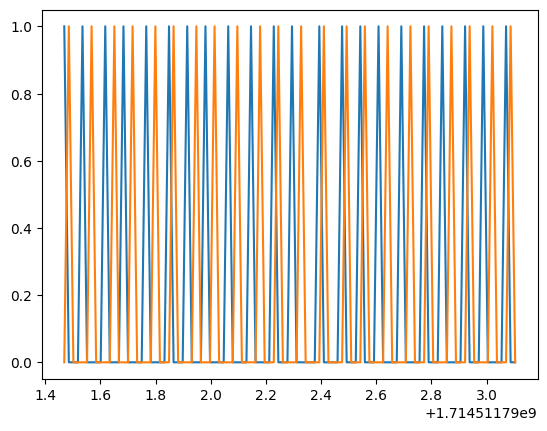

In [113]:
plt.figure()
N0 = 200
N1 = 300
plt.plot(x_common[N0:N1], y_frames[N0:N1])
plt.plot(x_common[N0:N1], y_imu[N0:N1])
# plt.plot(time_mes_imu)
plt.show()

# end

In [3]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# ax.view_init(15, 35)
# ax.quiver(0, 0, 0, [vec[0], qx/9], [vec[1], qy/9], [vec[2], qz/9], color='steelblue')
# fig.canvas.draw()
# data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


In [ ]:
# from math import atan2, sqrt, pi, degrees, radians, cos, sin
# i2c = busio.I2C((1, 14), (1, 15))
# device = Imu(i2c, address=0x4b)
# device.enable_feature(BNO_REPORT_GRAVITY)
# device.enable_feature(BNO_REPORT_ROTATION_VECTOR)
# device.enable_feature(BNO_REPORT_GEOMAGNETIC_ROTATION_VECTOR)

# while True:
#     quat_i, quat_j, quat_k, quat_real = device.quaternion
#     while (sqrt(quat_i * quat_i + quat_j * quat_j + quat_k * quat_k + quat_real * quat_real) == 0):
#         quat_i, quat_j, quat_k, quat_real = device.quaternion
#     # x, y, z = device.gravity
#     # print(device.gravity)
#     # print(sqrt(x*x + y*y + z*z))
#     heading = find_heading(quat_real, quat_i, quat_j, quat_k)
#     print(f"({cos(radians(heading))}, {sin(radians(heading))}, 0)")

In [ ]:
# display_handle=display(None, display_id=True)
# try:   
#     X = 640
#     Y = 480
#     while True:

#         qx, qy, qz = device.gravity
#         quat_i, quat_j, quat_k, quat_real = device.quaternion
#         heading = find_heading(quat_real, quat_i, quat_j, quat_k)
        
#         # the geomagnetic sensor is unstable
#         # Heading is calculated using geomagnetic vector
#         geo_quat_i, geo_quat_j, geo_quat_k, geo_quat_real = device.geomagnetic_quaternion
#         heading_geo = find_heading(geo_quat_real, geo_quat_i, geo_quat_j, geo_quat_k)
        
#         image = np.ones((Y, X), dtype = np.uint8)
#         image.fill(255)
#         image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

#         nx, ny, nz = cos(radians(heading)), sin(radians(heading)), 0.
#         angle_v = degrees(angle([qx, qy, qz], [nx, ny, nz]))
        
#         image = cv2.putText(image, f'quat: {int(heading)}', (100, 100), cv2.FONT_HERSHEY_SIMPLEX ,  
#                    1, (0, 0, 0) , 2, cv2.LINE_AA)
#         image = cv2.putText(image, f'geomag: {int(heading_geo)}', (100, 150), cv2.FONT_HERSHEY_SIMPLEX ,  
#                    1, (0, 0, 0) , 2, cv2.LINE_AA)

#         image = cv2.putText(image, f"({nx:.2}, {ny:.2}, {nz:.2})", (100, 200), cv2.FONT_HERSHEY_SIMPLEX ,  
#                    1, (0, 0, 0) , 2, cv2.LINE_AA)
        
#         image = cv2.putText(image, f"angle: {angle_v}", (100, 250), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 0) , 2, cv2.LINE_AA)
#         image = cv2.putText(image, f"grav: {qx:.2}, {qy:.2}, {qz:.2}", (100, 300), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 0) , 2, cv2.LINE_AA)

#         r = R.from_euler('y', angle_v - 90, degrees=True)
#         vec = [nx, ny, nz]
#         vec = r.apply(vec)
#         # r = R.from_euler('z', heading, degrees=True)
#         # vec = r.apply(vec)

#         image = cv2.putText(image, f"heading_vec: {vec[0]:.2}, {vec[1]:.2}, {vec[2]:.2}", (100, 350), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 0) , 2, cv2.LINE_AA)
#         # image = cv2.flip(image, 1)
#         # print(image.shape, type(image))
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')


#         vec_y = np.cross([qx/9, qy/9, -qz/9], [vec[0], vec[1], vec[2]])
#         ax.quiver(0, 0, 0, qx/9, qy/9, -qz/9, color='steelblue')
#         ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='b')
#         ax.quiver(0, 0, 0, vec_y[0], vec_y[1], vec_y[2], color='r')
#         # ax.quiver(0, 0, 0, nx, ny, nz, color='b')
#         # ax.quiver(0, 0, 0, 1, 2, 1)
#         ax.set_xlim([-1.1, 1.1])
#         ax.set_ylim([-1.1, 1.1])
#         ax.set_zlim([-1.1, 1.1])
#         fig.canvas.draw()

                
#         data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#         data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


#         angle_v2 = degrees(angle([qx, qy, qz], [vec[0], vec[1], vec[2]]))
#         data = cv2.putText(data, f"angle1: {angle_v}", (100, 100), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 0) , 2, cv2.LINE_AA)
#         data = cv2.putText(data, f"angl2e: {angle_v2}", (100, 150), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 0) , 2, cv2.LINE_AA)
        
        
        
#         _, data = cv2.imencode('.jpeg', data)
#         display_handle.update(Image(data=data.tobytes()))
        
# except KeyboardInterrupt:
#     display_handle.update(None)
#     pass